This script is a tutorial about installing and running megaman in Google Colab.

We will install megaman and use it to build a spectral embedding on uniform swiss roll example.

Run this script in Google Colab.
Because we need to use conda environment, we have to run our codes in bash script, as shown below.

Install conda

In [1]:
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:25
🔁 Restarting kernel...


In [ ]:
# create the conda environment
# as the running requirement of megaman, must use python <= 3.6
! conda create -n manifold_env python=3.6 -y

Install megaman, Start Spectral embedding

In [ ]:
# activate conda environment
%%bash
source activate manifold_env
# install megaman and all dependencies
conda update -n base -c conda-forge conda
pip install cython numpy scipy scikit-learn pyflann pyamg h5py plotly ipykernel matplotlib
conda install --channel=conda-forge -y pyflann
pip install git+https://github.com/mmp2/megaman.git
python

# start spectral embedding
import os
import sys
import itertools
import math
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
from scipy import stats
from sklearn import datasets
from sklearn import manifold
from megaman.geometry import Geometry
from megaman.embedding import SpectralEmbedding


# the plotting function
#----------------------------------------------------
def plot_2d_shape_all(datapoints, colors, title=None, figsize=(20, 20), marker_size=2, set_division=False, save_path=False,
                      show_plot=True, hide_axes=True):
    """
    parameters
        "datapoints": Returned matrix from sklearn manifold learning methods, for plotting.
        "colors": Dataset used to color each shape; can be None.
        "title": Name of the shape; None as default value.
        "figsize": Size of plot, 20 * 20 as default value.
        "marker_size": Size of marker, 2 as default value.
        "set_division": Choose whether set division in each axis scale;
        False as default value; if wanna set division, input real value.
        "save_path": The path for saving the plot; False as default value;
        if wanna to save plot, input absolute path for saving.
        "show_plot": Whether you want to display the generated plot;
        True as default value.
        "hide_axes": Whether you want to hide axes of generated plot;
        True as default value.
    post
        Plot and save all 2d shapes; each shape is plotted by combining first and
        another column in "datapoints".
    """
    num_of_plots = datapoints.shape[-1] - 1
    fig = plt.figure(figsize=figsize)
    
    for i in range(1, num_of_plots+1):
        sub_data = datapoints[:, [0,i]]
        x, y = sub_data.T
        ax = fig.add_subplot(math.ceil(num_of_plots/2), 2, i)
        ax.scatter(x, y, s=marker_size, c=colors)
        ax.set_title("v0, v"+str(i))

        if set_division != False:
            # set division in each axis scale
            ax.xaxis.set_major_locator(ticker.MultipleLocator(set_division))
            ax.yaxis.set_major_locator(ticker.MultipleLocator(set_division))
        
        if hide_axes:
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
    
    plt.suptitle(title, fontsize=20)
    if save_path != False:
        plt.savefig(save_path)
    if show_plot:
        plt.show(block=True)
#----------------------------------------------------


# dataset generation method
#----------------------------------------------------
def swiss_roll_dataset(length_phi, length_Z, datapoints=5000):
    length_phi = length_phi #length of swiss roll in angular direction
    length_Z = length_Z #length of swiss roll in z direction
    sigma = 0      #noise strength
    m = datapoints        #number of samples

    ##generate dataset
    np.random.seed(101) #set random seed to be 101
    phi = length_phi*np.random.rand(m)
    xi = np.random.rand(m)
    Z = length_Z*np.random.rand(m)
    X = 1./6*(phi + min(length_Z,length_phi) + sigma*xi)*np.sin(phi)
    Y = 1./6*(phi + min(length_Z,length_phi) + sigma*xi)*np.cos(phi)

    swiss_roll = np.array([X, Y, Z]).T
    swiss_roll = np.append(swiss_roll,[[0]*17]*m,1)
    #rotate with X coordiante
    theta = np.radians(90)
    rotation = np.identity(20)
    rotation[2,2]=np.cos(theta)
    rotation[1,2]=-np.sin(theta)
    rotation[2,1]=np.sin(theta)
    rotation[1,1]=np.cos(theta)
    swiss_roll=rotation.dot(swiss_roll.T).T
    
    return phi, Z, swiss_roll
#----------------------------------------------------


# build megaman Spectral Embedding model.
#----------------------------------------------------
def build_spectral(ignore_distance, kernel_bandwidth, n_components):
    adjacency_method = 'brute'
    adjacency_kwds = {'radius': ignore_distance} # ignore distances above this radius
    affinity_method = 'gaussian'
    affinity_kwds = {'radius': kernel_bandwidth} # A = exp(-||x - y||/radius^2)
    laplacian_method = 'geometric'

    geom  = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds,
                    affinity_method=affinity_method, affinity_kwds=affinity_kwds,
                    laplacian_method=laplacian_method)

    spectral = SpectralEmbedding(n_components=n_components, eigen_solver='lobpcg',
                                geom=geom)
    
    return spectral
#----------------------------------------------------


# swiss roll example
# we will build a uniform swiss roll with length_phi=4, length_z=3, 10000 datapoints
# we will build a spectral embedding with ignore_distance=1.1, kernel_bandwidth=0.4,
# n_components=7, using "lobpcg" as eigen_solver
# we will plot all combinations of our embedding result, colored by Z axis
#----------------------------------------------------
# generate the data
length_phi, length_Z = 4, 3
phi, Z, swiss_roll = swiss_roll_dataset(length_phi, length_Z, 10000)

# build the spectral embedding
spectral = build_spectral(1.1, 0.4, 7)
data_spectral = spectral.fit_transform(swiss_roll)

# all combinations, in one plot, color z
plot_2d_shape_all(data_spectral, Z, save_path="result.jpg")
#----------------------------------------------------

Our plot result here is stored in Google Colab file system, under "/content/result.jpg"
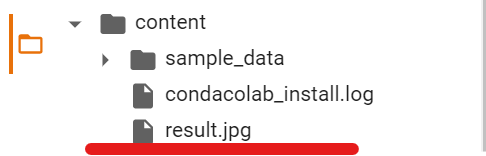

Display the embedding result

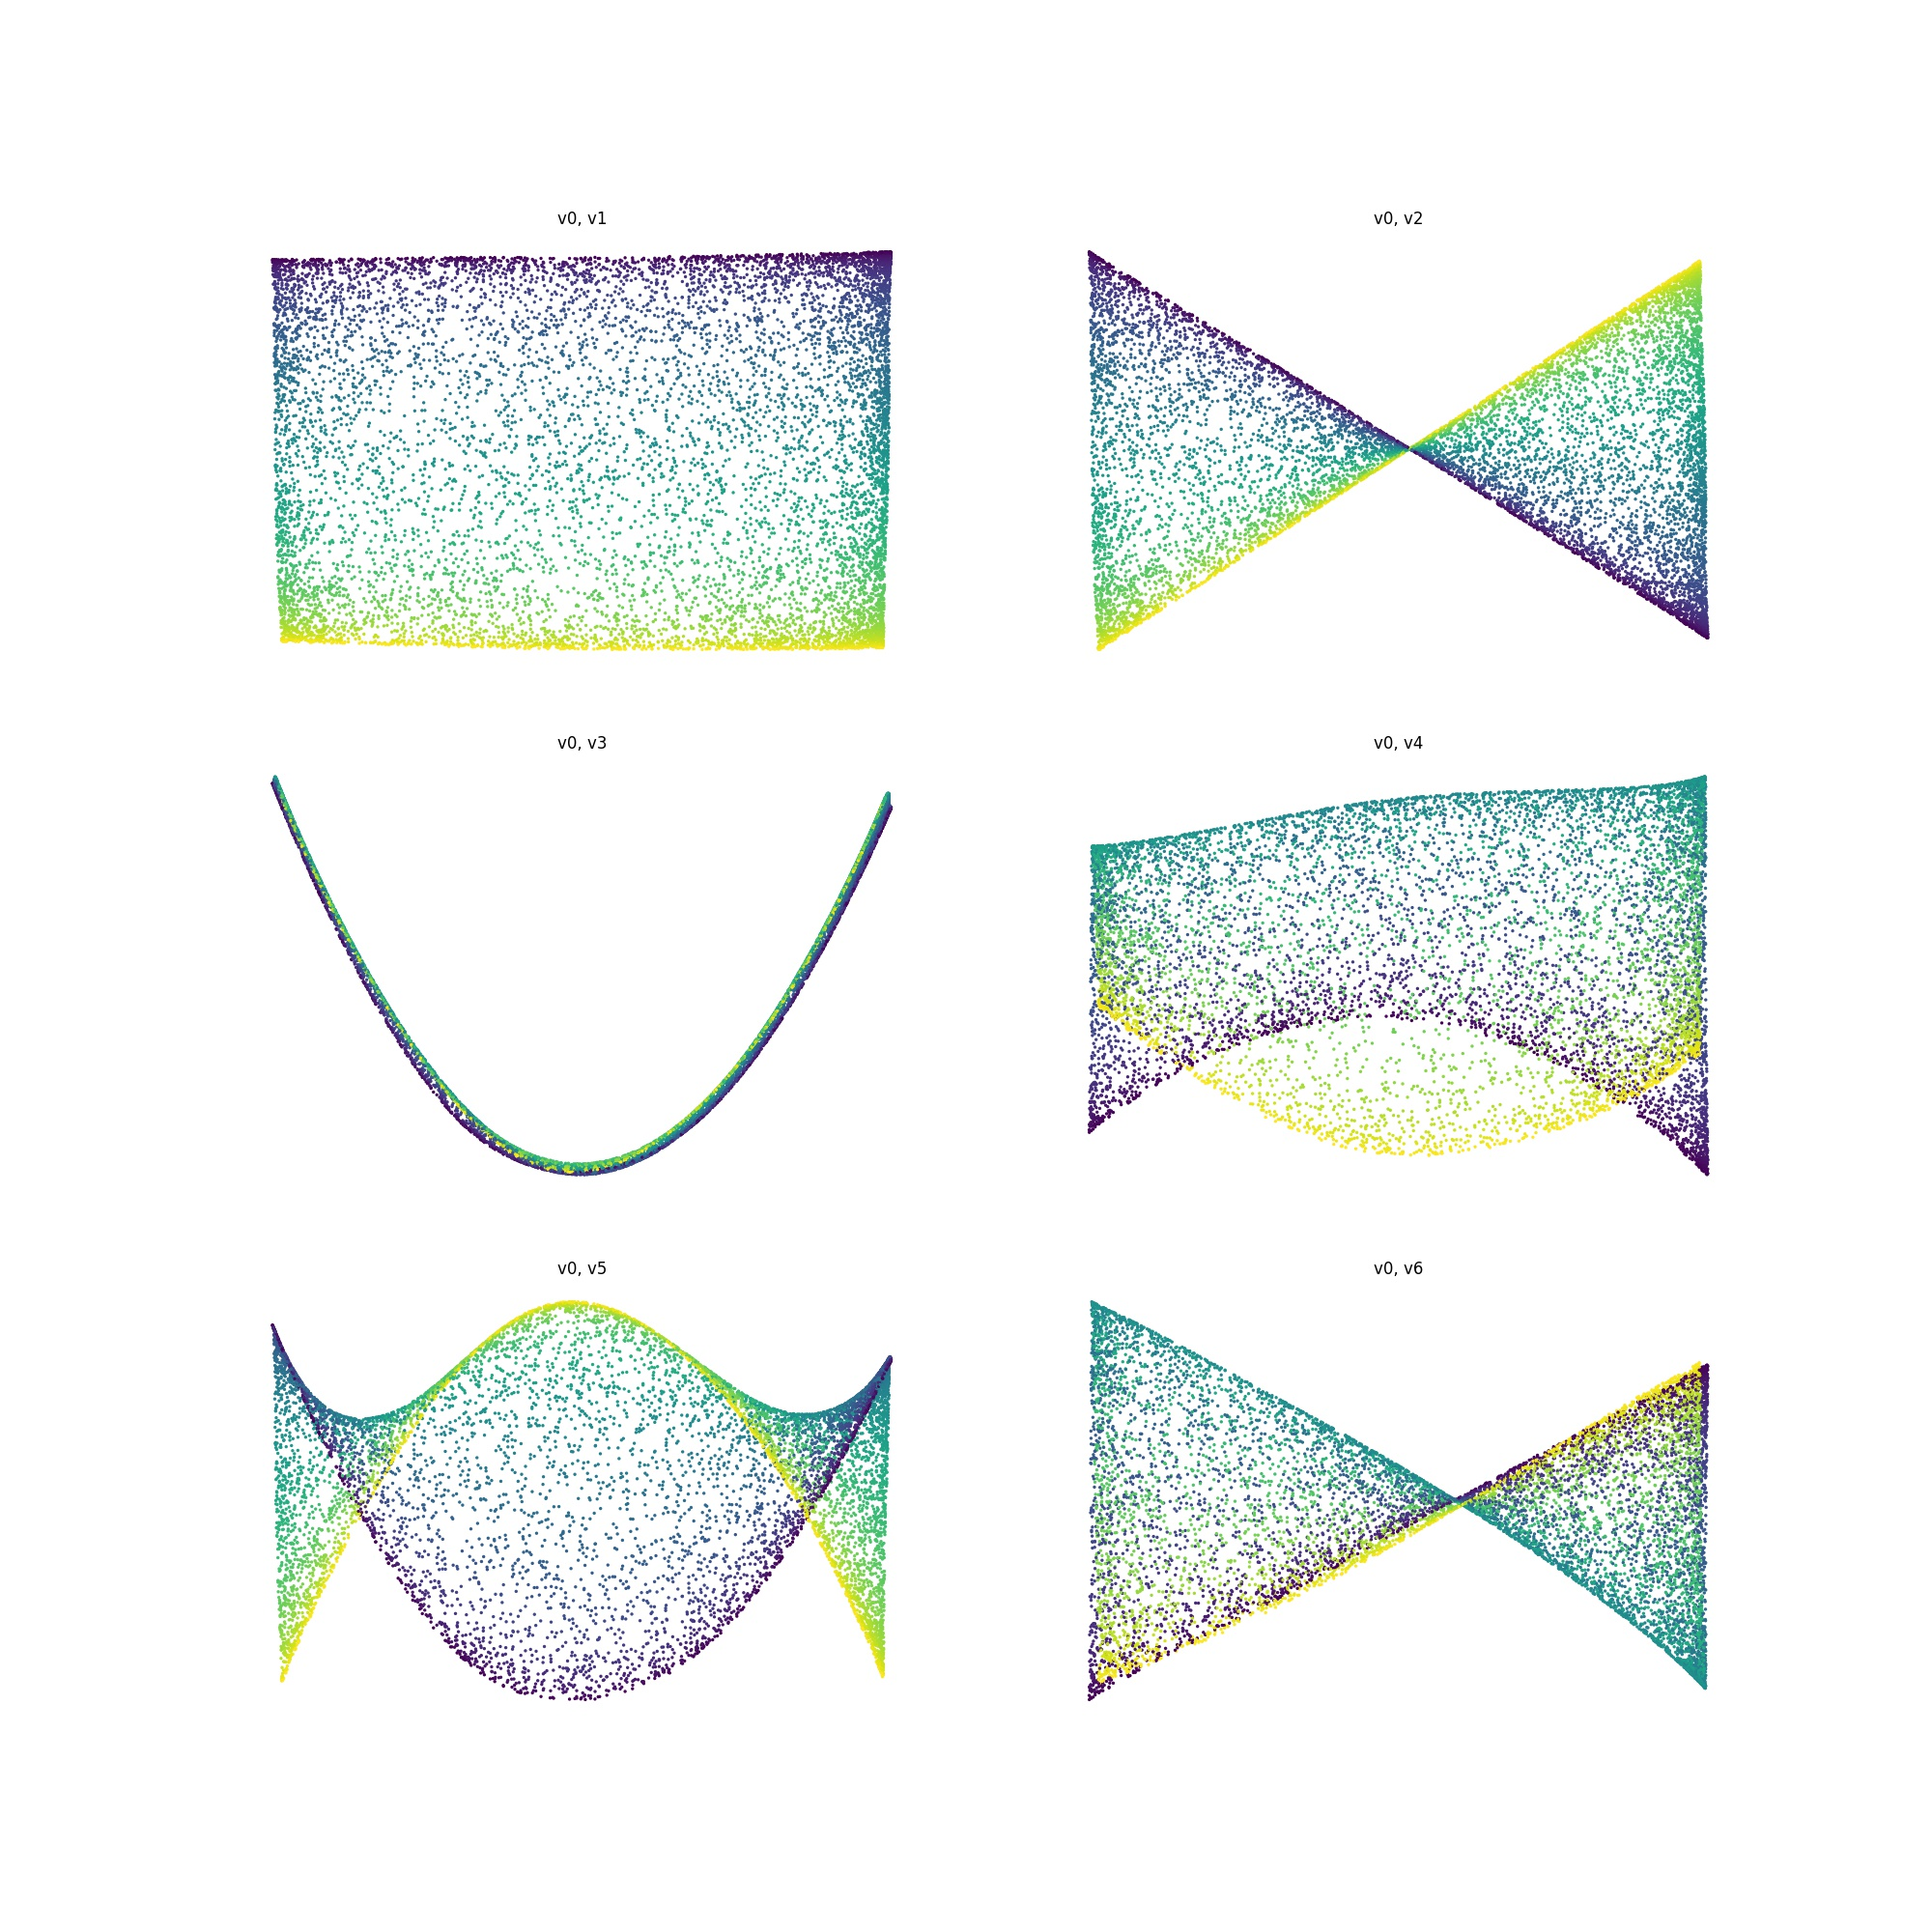

In [4]:
from IPython.display import Image

Image("/content/result.jpg")